# Reconstructing Brain MRI Images Using Convolutional Autoencoder

In [1]:
import os
import cv2
from keras.layers import *
from keras.layers import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K

import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
from sklearn.model_selection import train_test_split
import math
import glob
from matplotlib import pyplot as plt
%matplotlib inline

## Data and Image preprocessing

In [16]:
data = glob.glob(r'C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\Data\Pre-processed\*.gz')

In [17]:
data

['C:\\Users\\kiran\\Documents\\_UIS\\sem6\\BACH\\DementiaMRI\\Data\\Pre-processed\\101_sub-ADNI007S6120_ses-M012_T1w2_norm.nii.gz',
 'C:\\Users\\kiran\\Documents\\_UIS\\sem6\\BACH\\DementiaMRI\\Data\\Pre-processed\\103_sub-ADNI007S6255_ses-M012_T1w2_norm.nii.gz',
 'C:\\Users\\kiran\\Documents\\_UIS\\sem6\\BACH\\DementiaMRI\\Data\\Pre-processed\\104_sub-ADNI007S6255_ses-M024_T1w2_norm.nii.gz',
 'C:\\Users\\kiran\\Documents\\_UIS\\sem6\\BACH\\DementiaMRI\\Data\\Pre-processed\\107_sub-ADNI007S6323_ses-M000_T1w2_norm.nii.gz',
 'C:\\Users\\kiran\\Documents\\_UIS\\sem6\\BACH\\DementiaMRI\\Data\\Pre-processed\\108_sub-ADNI007S6323_ses-M030_T1w2_norm.nii.gz',
 'C:\\Users\\kiran\\Documents\\_UIS\\sem6\\BACH\\DementiaMRI\\Data\\Pre-processed\\109_sub-ADNI007S6455_ses-M000_T1w2_norm.nii.gz',
 'C:\\Users\\kiran\\Documents\\_UIS\\sem6\\BACH\\DementiaMRI\\Data\\Pre-processed\\110_sub-ADNI007S6455_ses-M024_T1w2_norm.nii.gz',
 'C:\\Users\\kiran\\Documents\\_UIS\\sem6\\BACH\\DementiaMRI\\Data\\Pre-proc

In [18]:
len(data)

338

In [19]:
images = []

In [21]:
images = np.array(images)
images.shape

(0,)

In [12]:
images = images.reshape(-1, 173,173,1)
images.shape

(0, 173, 173, 1)

In [13]:
temp = np.zeros([1530,176,176,1])
temp[:,3:,3:,:] = images
images = temp

ValueError: could not broadcast input array from shape (0,173,173,1) into shape (1530,173,173,1)

In [ ]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(images,test_size=0.2, random_state=42)

print("Dataset (images) shape: {shape}".format(shape=images.shape))                                                      

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

## Visiualize Data

NameError: name 'train_X' is not defined

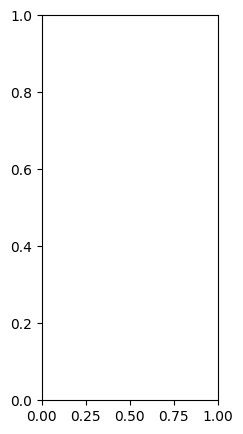

In [14]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_X[0], (176,176))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(valid_X[0], (176,176))
plt.imshow(curr_img, cmap='gray')

In [2]:
# IMPORT EVERYTHING****!!!
#from Architectures.AE_ADJ import AE # for some fucking reason importing this makes it not work? (reconstructs everything around the brain somehow)

#from Data.load import load, load_middle_slices
#from Visualizations.latent_space_projections import pPCA, pTSNE, pUMAP, pISOMAP, pENCODED, plot_multiple_datasets
#from Visualizations.plots import plot_middle_slices_in_range, plot_models_training_time, compare_models_loss_history, plot_images, compare_models_reconstruction
#from Metrics.metrics_tf import MSE_loss, NMSE_loss, NRMSE_loss, SSIM_loss
#from Metrics.metrics import NMSE, SSIM, NRMSE, MSE

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import Model, models, Input, activations, regularizers
from tensorflow.keras.layers import BatchNormalization, Dense, Conv2D, Flatten, UpSampling2D


from skimage.metrics import structural_similarity as ssim

import umap
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import tensorflow as tf
import tensorflow.keras.backend as K
import time
import math
import nibabel as nib

from glob import glob
import numpy as np
import nibabel as nib
from tqdm import tqdm
from scipy.ndimage import zoom


c:\Users\kiran\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

def load_middle_slices(
        dataset_path: str = "Pre-processed",  # Now takes the full dataset path instead of constructing it
        axis=["sagittal","axial","coronal"][0],
        crop: bool = True,
        normalize: bool = True,
        target_size: tuple | None = (80, 96),  # Only height and width since we extract a 2D slice
        train_test_split: float = 0.9,
        take: int = -1
    ):
    """
    :params:
    - dataset_path: Full path to the dataset folder.
    - crop: If True, images are cut in all axes such that only the non-zero voxels are included.
    - normalize: If True, voxel magnitudes are normalized between 0 and 1.
    - target_size: Downsampling target size. Set to None to keep original size.
    - train_test_split: Ratio of images used in the train set. Set to 1 to load everything into a single dataset.
    - take: Number of images to load. Set to -1 to load all available images.
    """

    #script_dir = os.path.dirname(os.path.abspath(__file__))  # Get the directory of this script
    #dataset_path = os.path.join(script_dir, dataset_name)  # Create the absolute path
    files = glob(os.path.join(dataset_path, "*.nii.gz"))  # Use absolute path for glob
    if take >= 0:
        files = files[:take]

    images = []

    def handle_image(img):
        if crop:
            brain_mask = img > 0.01
            bounds = np.where(brain_mask)
            x_min, x_max, y_min, y_max, z_min, z_max = (
                np.min(bounds[0]), np.max(bounds[0]),
                np.min(bounds[1]), np.max(bounds[1]),
                np.min(bounds[2]), np.max(bounds[2])
            )
            img = img[x_min-2:x_max+3, y_min-2:y_max+3, z_min-2:z_max+3]

        # Extract middle slice (x-axis)
        axes = {"sagittal": 0, "coronal": 1, "axial": 2}
        middle_x = img.shape[axes[axis]] // 2
        img = img.take(middle_x, axis=axes[axis])

        if normalize:
            q2m = .785700 / .475665
            fac = np.min([q2m / np.quantile(img, 0.98), 1. / np.max(img)])
            img *= fac

        if target_size is not None:
            zoom_factors = [t / b for t, b in zip(target_size, img.shape)]
            img = zoom(img, zoom_factors, order=1)  # Linear interpolation

        return [img]

    for file in tqdm(files, "Loading images"):
        img = nib.load(file).get_fdata()
        images.extend(handle_image(img))

    images = np.stack(images)

    if train_test_split >= 1 or train_test_split <= 0:
        return images

    idx_split = int(len(images) * train_test_split)
    train, test = images[:idx_split], images[idx_split:]

    return train, test

H_train2D, H_test2D = load_middle_slices(dataset_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\Data\Pre-processed", axis="sagittal", train_test_split=0.8, take=350)

Loading images: 100%|██████████| 338/338 [00:58<00:00,  5.79it/s]


In [56]:
AD_train2D, AD_test2D = load_middle_slices(dataset_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\Data\Pre-processed-AD", axis="sagittal", train_test_split=0.8, take=350)
AD = np.concatenate([AD_train2D, AD_test2D], axis=0)

Loading images: 100%|██████████| 26/26 [00:06<00:00,  3.81it/s]


## Model Build

In [ ]:
batch_size = 128
epochs = 300
inChannel = 1
x, y = 80, 96
input_img = Input(shape = (x, y, inChannel))

def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)


    #decoder
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [10]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 80, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 80, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 80, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 80, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 80, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 40, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 40, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 40, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 40, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 40, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 20, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 20, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 20, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 20, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 20, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 20, 24, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 20, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 20, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 20, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 40, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 40, 48, 32)     │        18,46

 Total params: 427,713 (1.63 MB)

 Trainable params: 426,433 (1.63 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [43]:
# autoencoder_train = 
autoencoder.fit(H_train2D, H_train2D, batch_size=batch_size,epochs=700,verbose=1,validation_data=(H_test2D, H_test2D))

Epoch 1/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0026 - val_loss: 0.0027
Epoch 2/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0026 - val_loss: 0.0027
Epoch 3/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0025 - val_loss: 0.0027
Epoch 4/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0023 - val_loss: 0.0025
Epoch 5/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0023 - val_loss: 0.0038
Epoch 6/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0030 - val_loss: 0.0032
Epoch 7/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0027 - val_loss: 0.0026
Epoch 8/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0024 - val_loss: 0.0032
Epoch 9/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0025 - val_loss: 0.0027
Epoch 10/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0023 - val_loss: 0.0025
Epoch 11/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0023 - val_loss: 0.0026
Epoch 12/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0023 - val_loss: 0.0028
Epoch 13/700


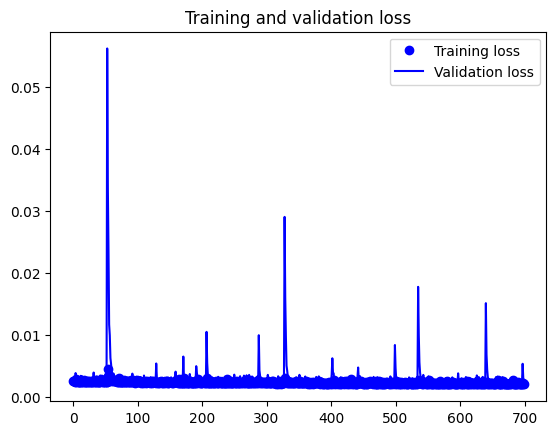

In [44]:
loss = autoencoder.history.history['loss']
val_loss = autoencoder.history.history['val_loss']
epochs = range(700)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [157]:
autoencoder.save_weights('autoencoder_mri.weights.h5')

In [40]:
#from tensorflow.keras import Model
#autoencoder = Model(inputs=input_img, outputs=autoencoder(input_img))
autoencoder = Model(input_img, autoencoder(input_img))
# autoencoder = Model(input_img, autoencoder(input_img))

TypeError: 'NoneType' object is not callable

In [158]:
autoencoder.load_weights('autoencoder_mri.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'autoencoder_mri.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder.summary()

In [80]:
pred = autoencoder.predict(H_test2D) # H_test2D, AD

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step 


Test Images


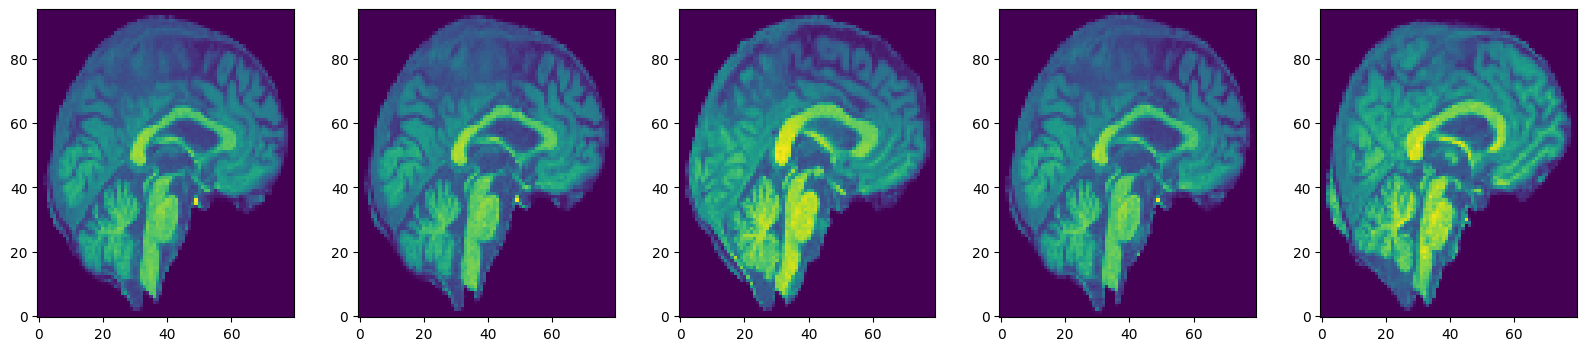

Reconstruction of Test Images


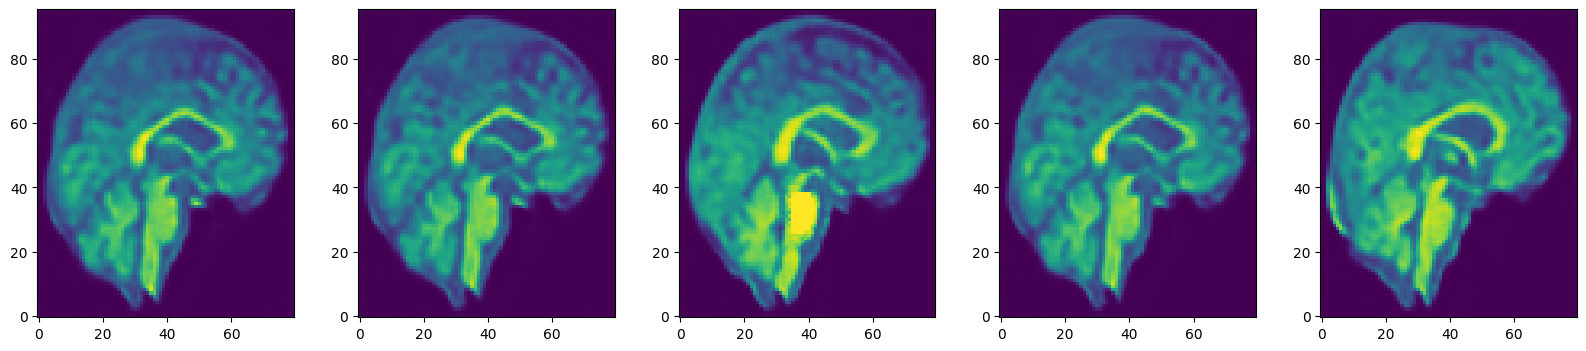

Difference


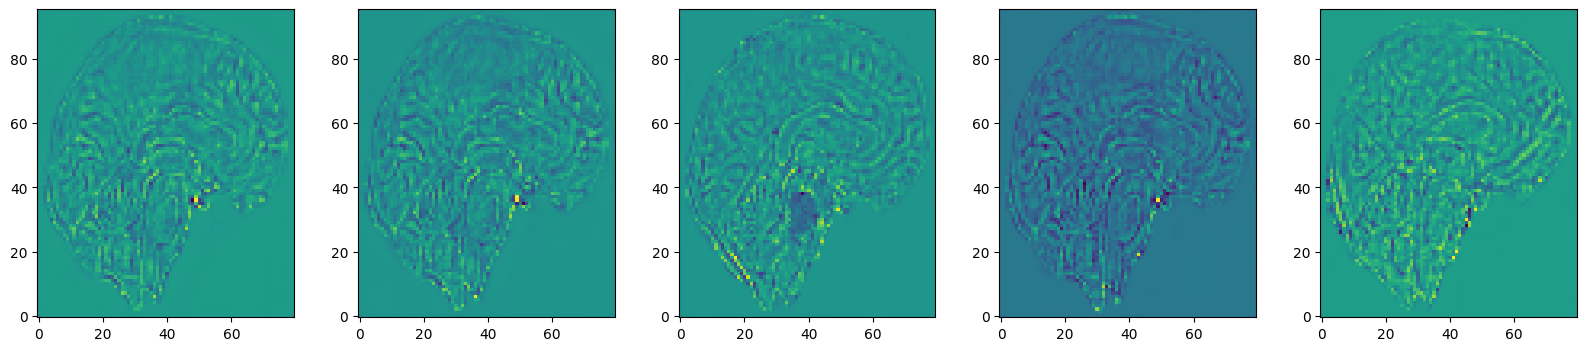

In [81]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(H_test2D[i].T, cmap='viridis',origin="lower")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i][:,:,0].T, cmap='viridis',origin="lower")  
plt.show()

plt.figure(figsize=(20, 4))
print("Difference")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(H_test2D[i].T - pred[i][:,:,0].T, cmap='viridis',origin="lower")  
plt.show()

### Predictions

In [63]:
[a,b,c]= np.shape(H_test2D)
mean = 0
sigma = 0.03
gauss = np.random.normal(mean,sigma,(a,b,c))
noisy_images = H_test2D + gauss

In [49]:
pred_noisy = autoencoder.predict(H_test2D)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step 


Noisy Test Images


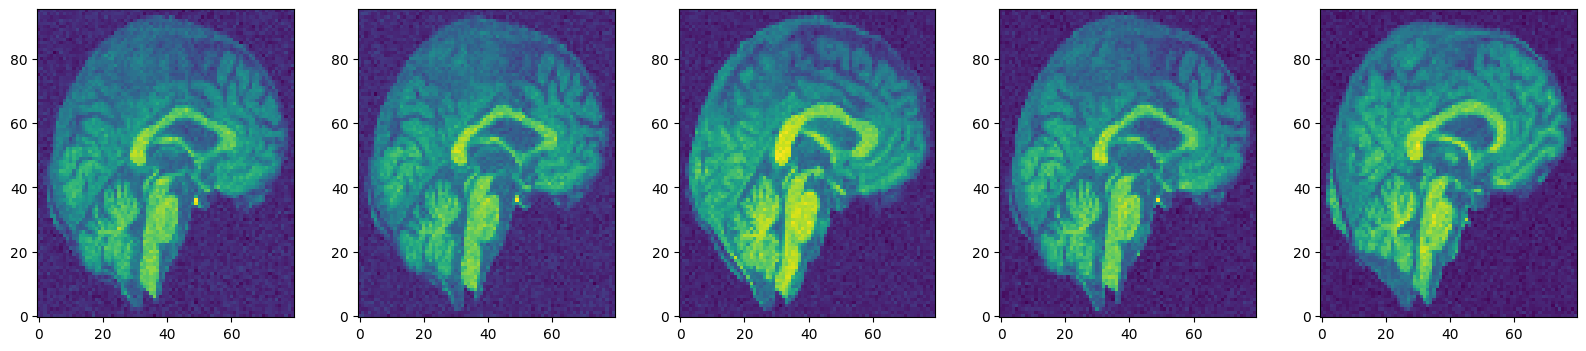

Reconstruction of Noisy Test Images


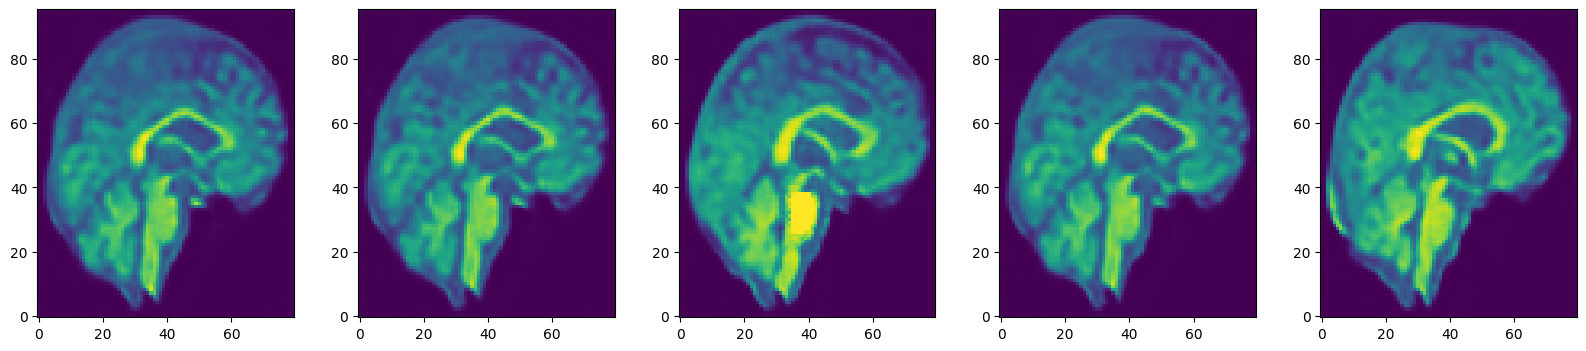

Difference


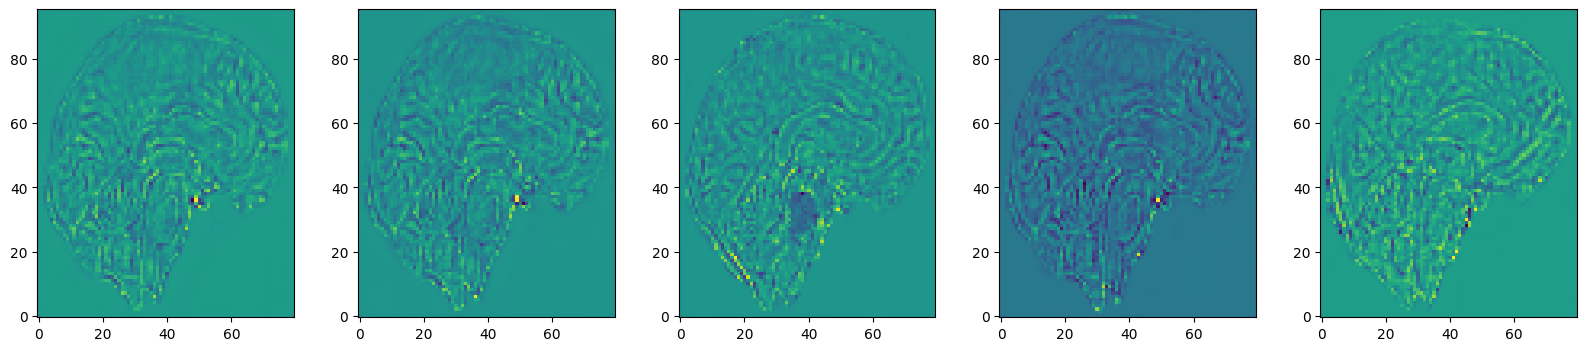

In [64]:
plt.figure(figsize=(20, 4))
print("Noisy Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(noisy_images[i].T, cmap='viridis', origin="lower")
plt.show()
plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred_noisy[i][:,:,0].T, cmap='viridis', origin="lower")
plt.show()

plt.figure(figsize=(20, 4))
print("Difference")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(H_test2D[i].T - pred_noisy[i][:,:,0].T, cmap='viridis',origin="lower")  
plt.show()

In [77]:

def SSIM(pred, actual):
    """Structural Similarity Index (SSIM)"""
    if pred.shape != actual.shape:
        pred.reshape(actual.shape)
    return ssim(pred, actual, data_range=actual.max() - actual.min())

In [79]:
import numpy as np
import math

valid_pred = autoencoder.predict(H_test2D)
valid_pred = np.squeeze(valid_pred)  # Remove extra dimension

mse = np.mean((H_test2D - valid_pred) ** 2)  # No more shape mismatch
psnr = 20 * math.log10(1.0 / math.sqrt(mse))

print("MSE:", mse)
print("PSNR:", psnr)
print("SSIM:", SSIM(H_test2D, valid_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step 
MSE: 0.002690598150248851
PSNR: 25.701511607131998
SSIM: 0.9075253087667261


In [74]:
print('PSNR of reconstructed validation images: {psnr}dB'.format(psnr=np.round(psnr,2)))

PSNR of reconstructed validation images: 25.7dB


In [75]:
noisy_pred = autoencoder.predict(noisy_images)
noisy_pred = np.squeeze(valid_pred)  # Remove extra dimension
mse =  np.mean((H_test2D - noisy_pred) ** 2)
psnr_noisy = 20 * math.log10( 1.0 / math.sqrt(mse))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step 


In [76]:
print('PSNR of reconstructed validation images: {psnr}dB'.format(psnr=np.round(psnr_noisy,2)))

PSNR of reconstructed validation images: 25.7dB
